In [76]:
#extracting data from zip file
import tarfile
import os

tar_file_path = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'  # Replace with your file path
extract_dir = '/kaggle/working/'  # Output directory

os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path=extract_dir)
    print("Extraction completed.")

#extracted_files = os.listdir(extract_dir)

Extraction completed.


In [77]:
#importing all modules required, and data preprocessing
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ResizeWithPadOrCropd, ToTensord
)
from monai.utils import set_determinism
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn.functional as F
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim 
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# Custom normalization to [0, 1] range
class NormalizeToOneRange(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = (d[key] - d[key].min()) / (d[key].max() - d[key].min())
        return d

# Define custom dataset for BraTS-style folders
class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self.get_valid_samples()  # Collect only valid samples

    def get_valid_samples(self):
        valid_samples = []
        for folder in sorted(os.listdir(self.root_dir)):
            folder_path = os.path.join(self.root_dir, folder)
            flair_path = os.path.join(folder_path, f"{folder}_flair.nii.gz")
            t1_path = os.path.join(folder_path, f"{folder}_t1.nii.gz")
            if os.path.exists(flair_path) and os.path.exists(t1_path):
                valid_samples.append({"image": flair_path, "label": t1_path})
        return valid_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

# Define padding collate function for batch consistency
def pad_collate_fn(batch):
    max_size = [256, 256]  # Target size for the 2D output
    padded_images, padded_labels = [], []

    for item in batch:
        img, lbl = item['image'], item['label']
        
        # Select the middle slice along the depth dimension for 2D representation
        img_2d = img[0, :, :, img.shape[-1] // 2]  # Select a 2D slice
        lbl_2d = lbl[0, :, :, lbl.shape[-1] // 2]
        
        # Resize to 256x256 and make it 3 channels by repeating the slice
        img_2d_resized = F.interpolate(img_2d.unsqueeze(0).unsqueeze(0), size=max_size, mode="bilinear", align_corners=False)
        lbl_2d_resized = F.interpolate(lbl_2d.unsqueeze(0).unsqueeze(0), size=max_size, mode="bilinear", align_corners=False)

        # Stack to 3 channels
        img_2d_resized = img_2d_resized.repeat(1, 3, 1, 1)
        lbl_2d_resized = lbl_2d_resized.repeat(1, 3, 1, 1)
        
        padded_images.append(img_2d_resized)
        padded_labels.append(lbl_2d_resized)
    
    return {'image': torch.cat(padded_images), 'label': torch.cat(padded_labels)}

def get_transforms():
    return Compose(
        [
            LoadImaged(keys=["image", "label"]),  # Load the images
            EnsureChannelFirstd(keys=["image", "label"]),  # Ensure channel first
            Orientationd(keys=["image", "label"], axcodes="RAS"),  # Ensure correct orientation
            Spacingd(keys=["image", "label"], pixdim=(2.0, 2.0, 2.0), mode=("bilinear", "nearest")),  # Resample images
            NormalizeToOneRange(keys=["image", "label"]),  # Normalize to [0, 1] range
            ToTensord(keys=["image", "label"]),  # Convert to tensors
        ]
    )

# Initialize dataset and DataLoader
root_dir = "/kaggle/working/"  # Update this with the correct directory path
batch_size = 1
set_determinism(seed=0)

transforms = get_transforms()
brats_dataset = BraTSDataset(root_dir=root_dir, transform=transforms)
train_loader = DataLoader(brats_dataset, batch_size=batch_size, collate_fn=pad_collate_fn, shuffle=True)

scaler = torch.cuda.amp.GradScaler()  # Automatic mixed precision for memory optimization

for batch in train_loader:
    with torch.cuda.amp.autocast():  # Use mixed precision in the forward pass
        print("Image shape:", batch['image'].shape)  # Should be (1, 3, 256, 256)
        print(batch['label'].shape)
    break

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.9 MB/s eta 0:00:0000:01


/tmp/ipykernel_30/404740336.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Automatic mixed precision for memory optimization


Image shape: torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


/tmp/ipykernel_30/404740336.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision in the forward pass


Batch image shape: torch.Size([1, 3, 256, 256])


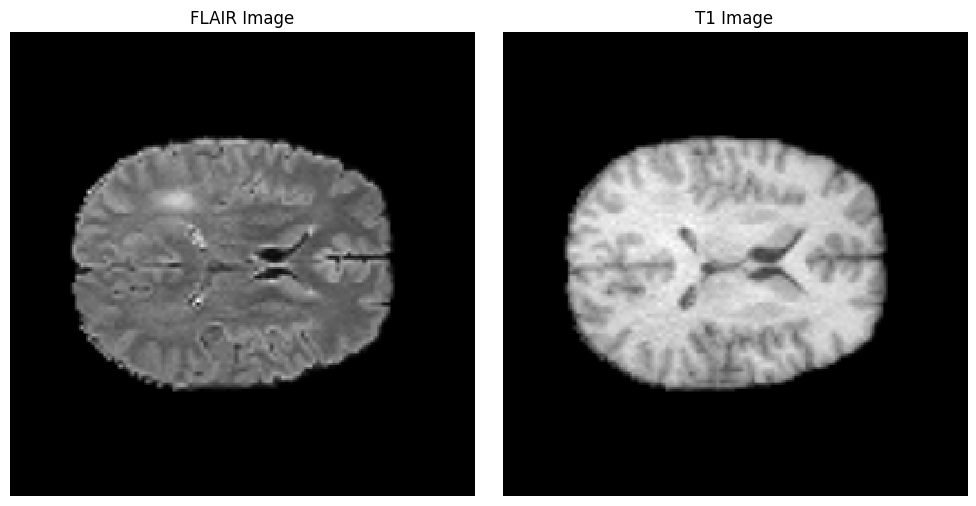

In [78]:
import matplotlib.pyplot as plt

# Function to display FLAIR and T1 images side by side
def display_flair_t1(flair_image, t1_image):
    flair_image = flair_image.squeeze(0).cpu()  
    t1_image = t1_image.squeeze(0).cpu() 

    # Plot FLAIR and T1 images side by side
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(flair_image, cmap='gray', interpolation='nearest') 
    plt.title('FLAIR Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(t1_image, cmap='gray', interpolation='nearest')
    plt.title('T1 Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_mri_slices(batch, slice_number):
    """
    Plots the specified slice from the FLAIR and T1 MRI images in the given batch.

    Parameters:
        batch (dict): A dictionary containing 'image' and 'label' tensors.
        slice_number (int): The index of the slice to be plotted (0-based).
    """
    # Check the shape of the batch images
    print(f"Batch image shape: {batch['image'].shape}")

    num_dimensions = len(batch['image'].shape)
    
    if num_dimensions == 4: 
        # Extract FLAIR and T1 images from the batch
        flair_images = batch['image'][:, 0, :, :]  # Extract FLAIR slice
        t1_images = batch['label'][:, 0, :, :]   # Extract T1 slice
    elif num_dimensions == 5:  # shape is (batch_size, channels, depth, height, width)
        if slice_number < 0 or slice_number >= batch['image'].shape[4]:
            raise ValueError(f"Slice number must be between 0 and {batch['image'].shape[4] - 1}")
        flair_images = batch['image'][:, 0, :, :, slice_number]  # Extract FLAIR slice
        t1_images = batch['label'][:, 0, :, :, slice_number]   # Extract T1 slice
    else:
        raise ValueError("Unsupported tensor shape")

    num_samples = flair_images.shape[0]

    for i in range(num_samples):
        display_flair_t1(flair_images[i].unsqueeze(0), t1_images[i].unsqueeze(0))

for batch in train_loader:
    plot_mri_slices(batch, slice_number=5)  
    break  

In [79]:
#2D GAN
import torch
import torch.nn as nn

# --- Residual Block ---
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection


# --- ResNet Generator ---
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_filters=64, num_res_blocks=9):
        """
        Args:
            input_nc (int): Number of input channels (e.g., 3 for RGB images).
            output_nc (int): Number of output channels (e.g., 3 for RGB images).
            num_filters (int): Nu mber of filters in the first convolution layer.
            num_res_blocks (int): Number of residual blocks in the generator.
        """
        super(ResNetGenerator, self).__init__()

        # Initial Convolution block
        model = [
            nn.Conv2d(input_nc, num_filters, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(num_filters),
            nn.ReLU(inplace=True)
        ]

        # Downsampling layers
        in_features = num_filters
        out_features = num_filters * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features *= 2

        # Residual blocks
        for _ in range(num_res_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling layers
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features //= 2

        # Output layer
        model += [
            nn.Conv2d(num_filters, output_nc, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh()  
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

generator = ResNetGenerator(input_nc=3, output_nc=3, num_filters=64, num_res_blocks=9)
input_image = torch.randn(1, 3, 256, 256)  # A sample batch of images
output_image = generator(input_image)
print(output_image.shape)  # Should output torch.Size([1, 3, 256, 256])

torch.Size([1, 3, 256, 256])


In [80]:
import torch
import torch.nn as nn

# --- PatchGAN Discriminator ---
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_nc, num_filters=64, num_layers=3):
        """
        Args:
            input_nc (int): Number of input channels (e.g., 3 for RGB images).
            num_filters (int): Number of filters in the first convolution layer.
            num_layers (int): Number of layers to downsample the input image.
        """
        super(PatchGANDiscriminator, self).__init__()

        # Initial layer: No normalization for the first layer
        model = [
            nn.Conv2d(input_nc, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        current_filters = num_filters
        for n in range(1, num_layers):
            next_filters = min(current_filters * 2, 512)
            model += [
                nn.Conv2d(current_filters, next_filters, kernel_size=4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(next_filters),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            current_filters = next_filters

        # Final convolution layer to produce a single-channel output
        model += [
            nn.Conv2d(current_filters, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


discriminator = PatchGANDiscriminator(input_nc=3, num_filters=64, num_layers=3)
input_image = torch.randn(1, 3, 256, 256)  # A sample batch of images
output = discriminator(input_image)
print(output.shape)  # Should output torch.Size([1, 1, 31, 31])

torch.Size([1, 1, 31, 31])


In [81]:
import torch
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Register hooks to capture activations and gradients
        self.hook_activation = target_layer.register_forward_hook(self.save_activation)
        self.hook_gradient = target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, output):
        # Perform backward pass to get gradients with respect to the output
        self.model.zero_grad()
        output.backward(torch.ones_like(output), retain_graph=True)

        # Compute the weights (average gradients over all spatial locations)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Compute the weighted sum of activations
        weighted_activations = weights * self.activations

        # Sum along the channel dimension to get the final heatmap
        heatmap = weighted_activations.sum(dim=1, keepdim=True)

        # Normalize the heatmap to [0, 1]
        heatmap = torch.nn.functional.relu(heatmap)
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()

        return heatmap

    def remove_hooks(self):
        self.hook_activation.remove()
        self.hook_gradient.remove()


/tmp/ipykernel_30/223204012.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/opt/conda/lib/python3.10/site

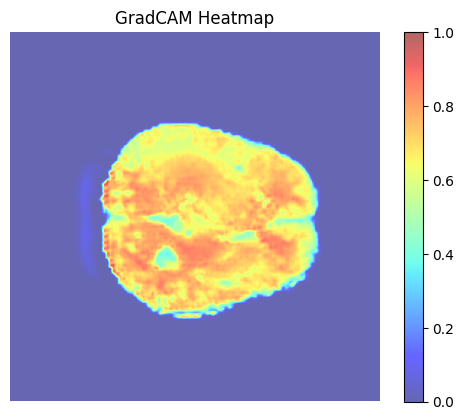

In [82]:
data_iter = iter(train_loader)
batch = next(data_iter)

device="cpu"
# Initialize models
generator_flair_to_t1 = ResNetGenerator(input_nc=3, output_nc=3, num_filters=64, num_res_blocks=9).to(device)

# Define the path to the saved checkpoint
checkpoint_path = '/kaggle/input/epoch-20/pytorch/default/1/checkpoint_final (16).pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
generator_flair_to_t1.load_state_dict(checkpoint['generator_flair_to_t1_state_dict'])

# Move the FLAIR image to the device
real_flair = batch['image'].to(device)  # FLAIR image as input

# Set model to evaluation mode
generator_flair_to_t1.eval()

# Select the target layer (last convolutional layer before Tanh)
# Last Conv2d layer (index 24)
target_layer = generator_flair_to_t1.model[24]

# Create GradCAM object
grad_cam = GradCAM(generator_flair_to_t1, target_layer)

# Ensure requires_grad is True for the input image (real_flair)
real_flair.requires_grad_()  

# Generate output using the generator model (in evaluation mode)
generated_t1 = generator_flair_to_t1(real_flair)

# Generate GradCAM heatmap
heatmap = grad_cam.generate_heatmap(generated_t1)

# Convert heatmap to numpy for visualization
heatmap = heatmap.squeeze().cpu().detach().numpy()

# Visualize the GradCAM heatmap
plt.imshow(heatmap, cmap='jet', alpha=0.6)
plt.colorbar()
plt.title("GradCAM Heatmap")
plt.axis('off')
plt.show()

# Clean up hooks
grad_cam.remove_hooks()


In [83]:
#training loop, the error shown under is due to keyboard interrupt while execution
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MultiScaleDiscriminator(nn.Module):
    def __init__(self, input_nc, num_filters=64, num_layers=3):
        super(MultiScaleDiscriminator, self).__init__()
        self.discriminators = nn.ModuleList()
        self.discriminators.append(PatchGANDiscriminator(input_nc, num_filters, num_layers))

    def forward(self, x):
        return [disc(x) for disc in self.discriminators]

# Initialize models
generator_flair_to_t1 = ResNetGenerator(input_nc=3, output_nc=3, num_filters=64, num_res_blocks=9).to(device)
generator_t1_to_flair = ResNetGenerator(input_nc=3, output_nc=3, num_filters=64, num_res_blocks=9).to(device)
discriminator_flair = MultiScaleDiscriminator(input_nc=3, num_filters=64, num_layers=3).to(device)
discriminator_t1 = MultiScaleDiscriminator(input_nc=3, num_filters=64, num_layers=3).to(device)

# Initialize optimizers
optimizer_G = optim.Adam(
    list(generator_flair_to_t1.parameters()) + list(generator_t1_to_flair.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

optimizer_D_flair = optim.Adam(discriminator_flair.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_t1 = optim.Adam(discriminator_t1.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Define loss functions
criterion_GAN = nn.MSELoss()  # Adversarial loss
criterion_L1 = nn.L1Loss()     # L1 reconstruction loss

# Pre-trained VGG model for perceptual loss
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(fake, real):
    fake_features = vgg(fake)
    real_features = vgg(real)
    return nn.L1Loss()(fake_features, real_features)

# Function to calculate SSIM loss
def ssim_loss(fake, real):
    # Detach tensors to prevent gradient tracking and convert to numpy arrays
    fake_np = fake.detach().permute(0, 2, 3, 1).cpu().numpy()
    real_np = real.detach().permute(0, 2, 3, 1).cpu().numpy()
    
    ssim_scores = [
        ssim(fake_np[i], real_np[i], win_size=3, channel_axis=2, data_range=1.0)  # Add data_range parameter
        for i in range(fake_np.shape[0])
    ]
    ssim_avg = torch.tensor(ssim_scores).mean().to(device)
    return 1 - ssim_avg 



# Define the path to the saved checkpoint
checkpoint_path = '/kaggle/input/epoch-20/pytorch/default/1/checkpoint_final (16).pth'
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load models' state dictionaries
generator_flair_to_t1.load_state_dict(checkpoint['generator_flair_to_t1_state_dict'])
generator_t1_to_flair.load_state_dict(checkpoint['generator_t1_to_flair_state_dict'])
discriminator_flair.load_state_dict(checkpoint['discriminator_flair_state_dict'])
discriminator_t1.load_state_dict(checkpoint['discriminator_t1_state_dict'])

# Load optimizers' state dictionaries
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D_flair.load_state_dict(checkpoint['optimizer_D_flair_state_dict'])
optimizer_D_t1.load_state_dict(checkpoint['optimizer_D_t1_state_dict'])

# Load the last completed epoch if you want to continue training
start_epoch = checkpoint['epoch']

print(f"Checkpoint loaded. Resuming from epoch {start_epoch + 1}.")

num_epochs = 5 

# Lists to store losses
G_losses = []
D_flair_losses = []
D_t1_losses = []

# Training loop
for epoch in range(num_epochs):
    generator_flair_to_t1.train()
    generator_t1_to_flair.train()
    discriminator_flair.train()
    discriminator_t1.train()

    # Lists to store epoch losses
    epoch_G_loss = 0.0
    epoch_D_flair_loss = 0.0
    epoch_D_t1_loss = 0.0

    # Iterate through the train_loader
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', total=len(train_loader)):
        # Get images from the dataloader
        real_flair = batch['image'].to(device)  # Flair images
        real_t1 = batch['label'].to(device)  # T1 images

        # ---- Train Generators ----
        optimizer_G.zero_grad()

        # Generate fake images
        fake_t1 = generator_flair_to_t1(real_flair)  # Flair to T1
        fake_flair = generator_t1_to_flair(real_t1)  # T1 to Flair

        # Calculate L1 and SSIM losses
        loss_L1_flair_to_t1 = criterion_L1(fake_t1, real_t1)
        loss_L1_t1_to_flair = criterion_L1(fake_flair, real_flair)
        
        loss_SSIM_flair_to_t1 = ssim_loss(fake_t1, real_t1)
        loss_SSIM_t1_to_flair = ssim_loss(fake_flair, real_flair)

        # Calculate GAN loss
        loss_GAN_flair_to_t1 = sum(criterion_GAN(output, torch.ones_like(output).to(device)) for output in discriminator_t1(fake_t1)) / len(discriminator_t1(fake_t1))
        loss_GAN_t1_to_flair = sum(criterion_GAN(output, torch.ones_like(output).to(device)) for output in discriminator_flair(fake_flair)) / len(discriminator_flair(fake_flair))

        # Total generator loss (Pix2Pix style)
        total_G_loss = (
            loss_GAN_flair_to_t1 +
            loss_GAN_t1_to_flair +
            100 * (loss_L1_flair_to_t1 + loss_L1_t1_to_flair) +  # Increased weight for L1 loss
            10 * (loss_SSIM_flair_to_t1 + loss_SSIM_t1_to_flair)  # SSIM loss with chosen weight
        )

        total_G_loss.backward()
        optimizer_G.step()

        # ---- Train Discriminators ----
        optimizer_D_flair.zero_grad()
        optimizer_D_t1.zero_grad()

        # Calculate adversarial loss for Discriminator Flair
        real_flair_outputs = discriminator_flair(real_flair)
        fake_flair_outputs = discriminator_flair(fake_flair.detach())
        
        loss_D_flair_real = sum(criterion_GAN(output, torch.ones_like(output).to(device)) for output in real_flair_outputs) / len(real_flair_outputs)
        loss_D_flair_fake = sum(criterion_GAN(output, torch.zeros_like(output).to(device)) for output in fake_flair_outputs) / len(fake_flair_outputs)
        loss_D_flair = (loss_D_flair_real + loss_D_flair_fake) * 0.5
        loss_D_flair.backward()
        optimizer_D_flair.step()

        # Calculate adversarial loss for Discriminator T1
        real_t1_outputs = discriminator_t1(real_t1)
        fake_t1_outputs = discriminator_t1(fake_t1.detach())
        
        loss_D_t1_real = sum(criterion_GAN(output, torch.ones_like(output).to(device)) for output in real_t1_outputs) / len(real_t1_outputs)
        loss_D_t1_fake = sum(criterion_GAN(output, torch.zeros_like(output).to(device)) for output in fake_t1_outputs) / len(fake_t1_outputs)
        loss_D_t1 = (loss_D_t1_real + loss_D_t1_fake) * 0.5
        loss_D_t1.backward()
        optimizer_D_t1.step()

        # Accumulate losses for averaging later
        epoch_G_loss += total_G_loss.item()
        epoch_D_flair_loss += loss_D_flair.item()
        epoch_D_t1_loss += loss_D_t1.item()

    # Average the losses for the epoch
    avg_G_loss = epoch_G_loss / len(train_loader)
    avg_D_flair_loss = epoch_D_flair_loss / len(train_loader)
    avg_D_t1_loss = epoch_D_t1_loss / len(train_loader)

    # Print the average losses for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Generator Loss: {avg_G_loss:.4f}, '
          f'Discriminator Flair Loss: {avg_D_flair_loss:.4f}, '
          f'Discriminator T1 Loss: {avg_D_t1_loss:.4f}')

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'generator_flair_to_t1_state_dict': generator_flair_to_t1.state_dict(),
        'generator_t1_to_flair_state_dict': generator_t1_to_flair.state_dict(),
        'discriminator_flair_state_dict': discriminator_flair.state_dict(),
        'discriminator_t1_state_dict': discriminator_t1.state_di2ct(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_flair_state_dict': optimizer_D_flair.state_dict(),
        'optimizer_D_t1_state_dict': optimizer_D_t1.state_dict()
    }, f'checkpoint_epoch_{epoch + 1}.pth')

print("Training completed.")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 202MB/s]  
/tmp/ipykernel_30/805701872.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to const

Checkpoint loaded. Resuming from epoch 6.


Epoch 1/5:   0%|          | 2/1251 [00:02<29:49,  1.43s/it]


KeyboardInterrupt: 

In [ ]:
# Save a single checkpoint after training
checkpoint_path = 'checkpoint_final.pth'  # Save as a single final checkpoint
torch.save({
    'epoch': num_epochs,
    'generator_flair_to_t1_state_dict': generator_flair_to_t1.state_dict(),
    'generator_t1_to_flair_state_dict': generator_t1_to_flair.state_dict(),
    'discriminator_flair_state_dict': discriminator_flair.state_dict(),
    'discriminator_t1_state_dict': discriminator_t1.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_flair_state_dict': optimizer_D_flair.state_dict(),
    'optimizer_D_t1_state_dict': optimizer_D_t1.state_dict(),
}, checkpoint_path)

In [86]:
#validation-loop
#the code to load val-loader is defined after confusion matrix
# Define the MSE loss
criterion_MSE = nn.MSELoss()

# Define the path to the saved checkpoint
checkpoint_path = '/kaggle/input/epoch-20/pytorch/default/1/checkpoint_final (16).pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load models' state dictionaries
generator_flair_to_t1.load_state_dict(checkpoint['generator_flair_to_t1_state_dict'])
generator_t1_to_flair.load_state_dict(checkpoint['generator_t1_to_flair_state_dict'])
discriminator_flair.load_state_dict(checkpoint['discriminator_flair_state_dict'])
discriminator_t1.load_state_dict(checkpoint['discriminator_t1_state_dict'])

# Set the models to evaluation mode
generator_flair_to_t1.eval()
generator_t1_to_flair.eval()
discriminator_flair.eval()
discriminator_t1.eval()


threshold = 0.5

# Initialize metric calculators
psnr_calculator = PeakSignalNoiseRatio().to(device)
ssim_calculator = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Initialize lists to store values for computing metrics
val_losses, val_psnrs, val_ssims = [], [], []
all_true_labels = []
all_pred_labels = []

# Define the MSE loss
criterion_MSE = nn.MSELoss()

# Validation loop
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation"):
        real_flair = batch['image'].to(device)
        real_t1 = batch['label'].to(device)
        
        # Generate fake images using the trained generators
        fake_t1 = generator_flair_to_t1(real_flair)
        fake_flair = generator_t1_to_flair(real_t1)

        # Calculate the MSE loss
        loss_MSE_flair_to_t1 = criterion_MSE(fake_t1, real_t1)
        loss_MSE_t1_to_flair = criterion_MSE(fake_flair, real_flair)
        val_G_loss = (loss_MSE_flair_to_t1 + loss_MSE_t1_to_flair) / 2
        val_losses.append(val_G_loss.item())

        # Calculate PSNR and SSIM for FLAIR to T1 and T1 to FLAIR
        psnr_flair_to_t1 = psnr_calculator(fake_t1, real_t1).item()
        psnr_t1_to_flair = psnr_calculator(fake_flair, real_flair).item()
        val_psnrs.append((psnr_flair_to_t1 + psnr_t1_to_flair) / 2)

        ssim_flair_to_t1 = ssim_calculator(fake_t1, real_t1).item()
        ssim_t1_to_flair = ssim_calculator(fake_flair, real_flair).item()
        val_ssims.append((ssim_flair_to_t1 + ssim_t1_to_flair) / 2)

        # Flatten the tensors to compare pixel-wise for classification
        fake_t1_flat = fake_t1.cpu().numpy().flatten()
        real_t1_flat = real_t1.cpu().numpy().flatten()

        fake_flair_flat = fake_flair.cpu().numpy().flatten()
        real_flair_flat = real_flair.cpu().numpy().flatten()

        # Convert to binary classification (Thresholded prediction)
        fake_t1_bin = (fake_t1_flat >= threshold).astype(int)
        real_t1_bin = (real_t1_flat >= threshold).astype(int)

        fake_flair_bin = (fake_flair_flat >= threshold).astype(int)
        real_flair_bin = (real_flair_flat >= threshold).astype(int)

        # Collect the true and predicted labels for evaluation
        all_true_labels.append(real_t1_bin)
        all_pred_labels.append(fake_t1_bin)

        # Same for T1 to FLAIR
        all_true_labels.append(real_flair_bin)
        all_pred_labels.append(fake_flair_bin)

# Flatten the lists of labels
all_true_labels = np.concatenate(all_true_labels)
all_pred_labels = np.concatenate(all_pred_labels)

# Compute Precision, Recall, F1 Score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_pred_labels, average='binary')

# Compute average PSNR and SSIM
avg_psnr = np.mean(val_psnrs)
avg_ssim = np.mean(val_ssims)

# Print metrics
print(f"Validation Loss: {np.mean(val_losses):.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

/tmp/ipykernel_30/3319259175.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Validation: 100%|██████████| 

Validation Loss: 0.0044
Average PSNR: 21.7306
Average SSIM: 0.8818
Precision: 0.5606
Recall: 0.5575
F1 Score: 0.5590


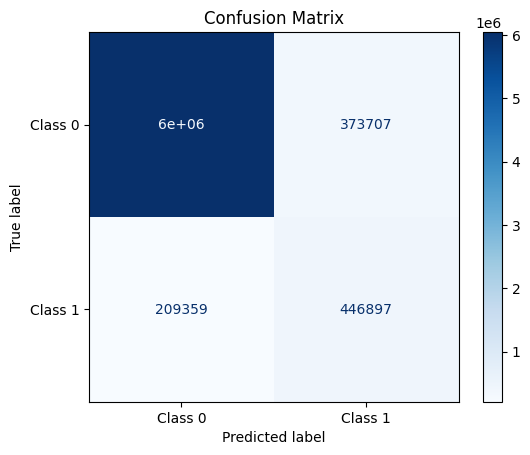

In [13]:
#confusion matrix
threshold = 0.5

all_true_labels = []
all_pred_labels = []

# No gradients required for evaluation
with torch.no_grad():
    for batch in val_loader:
        # Get real images and ground truth binary labels
        real_flair = batch['image'].to(device)
        real_t1 = batch['label'].to(device)

        # Generate predictions
        fake_t1 = generator_flair_to_t1(real_flair)
        
        # Convert to binary masks using threshold
        pred_labels = (fake_t1 > threshold).int().cpu().numpy().flatten()
        true_labels = (real_t1 > threshold).int().cpu().numpy().flatten()
        
        # Append to lists
        all_pred_labels.extend(pred_labels)
        all_true_labels.extend(true_labels)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [85]:
#val-loader 
class NormalizeToOneRange(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = (d[key] - d[key].min()) / (d[key].max() - d[key].min())
        return d

class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self.get_valid_samples()

    def get_valid_samples(self):
        valid_samples = []
        
        # Iterate through all GLI folders 
        for gli_folder in sorted(os.listdir(self.root_dir)):
            gli_path = os.path.join(self.root_dir, gli_folder)
            if not os.path.isdir(gli_path):
                continue
                
            # Find the specific modality folders
            t1_folder = os.path.join(gli_path, f"{gli_folder}-t1n.nii")
            flair_folder = os.path.join(gli_path, f"{gli_folder}-t2f.nii")
            
            # Look for the specific files in these folders
            if os.path.exists(t1_folder) and os.path.exists(flair_folder):
                t1_file = glob.glob(os.path.join(t1_folder, "*brain_t1.nii"))
                flair_file = glob.glob(os.path.join(flair_folder, "*brain_flair.nii"))
                
                if flair_file and t1_file:
                    valid_samples.append({
                        "image": flair_file[0],  
                        "label": t1_file[0]     
                    })
    
        
        print(f"Total samples found: {len(valid_samples)}")
        return valid_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

def pad_collate_fn(batch):
    max_size = [256, 256]  # Target size for the 2D output
    padded_images, padded_labels = [], []

    for item in batch:
        img, lbl = item['image'], item['label']
        
        # Select the middle slice along the depth dimension for 2D representation
        img_2d = img[0, :, :, img.shape[-1] // 2] 
        lbl_2d = lbl[0, :, :, lbl.shape[-1] // 2]
        
        # Resize to 256x256 and make it 3 channels by repeating the slice
        img_2d_resized = F.interpolate(img_2d.unsqueeze(0).unsqueeze(0), size=max_size, mode="bilinear", align_corners=False)
        lbl_2d_resized = F.interpolate(lbl_2d.unsqueeze(0).unsqueeze(0), size=max_size, mode="bilinear", align_corners=False)

        # Stack to 3 channels
        img_2d_resized = img_2d_resized.repeat(1, 3, 1, 1)
        lbl_2d_resized = lbl_2d_resized.repeat(1, 3, 1, 1)
        
        padded_images.append(img_2d_resized)
        padded_labels.append(lbl_2d_resized)
    
    return {'image': torch.cat(padded_images), 'label': torch.cat(padded_labels)}

def get_transforms():
    return Compose(
        [
            LoadImaged(keys=["image", "label"]),  # Load the images
            EnsureChannelFirstd(keys=["image", "label"]),  # Ensure channel first
            Orientationd(keys=["image", "label"], axcodes="RAS"),  # Ensure correct orientation
            Spacingd(keys=["image", "label"], pixdim=(2.0, 2.0, 2.0), mode=("bilinear", "nearest")),  # Resample images
            NormalizeToOneRange(keys=["image", "label"]),  # Normalize to [0, 1] range
            ToTensord(keys=["image", "label"]),  # Convert to tensors
        ]
    )

# Initialize dataset and DataLoader
root_dir = "/kaggle/input/brats-2023-adult-glioma/ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData/ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData"  # Update this with the correct directory path
batch_size = 1
set_determinism(seed=0)

transforms = get_transforms()
brats_dataset = BraTSDataset(root_dir=root_dir, transform=transforms)
val_loader = DataLoader(brats_dataset, batch_size=batch_size, collate_fn=pad_collate_fn, shuffle=True)

# Mixed Precision and Usage Example:
scaler = torch.cuda.amp.GradScaler()  # Automatic mixed precision for memory optimization

for batch in val_loader:
    with torch.cuda.amp.autocast():  # Use mixed precision in the forward pass
        print("Image shape:", batch['image'].shape)  # Should be (1, 3, 256, 256)
        print("Label shape:", batch['label'].shape)
    break

Total samples found: 36


/tmp/ipykernel_30/3095557702.py:104: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Automatic mixed precision for memory optimization


Image shape: torch.Size([1, 3, 256, 256])
Label shape: torch.Size([1, 3, 256, 256])


/tmp/ipykernel_30/3095557702.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision in the forward pass


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


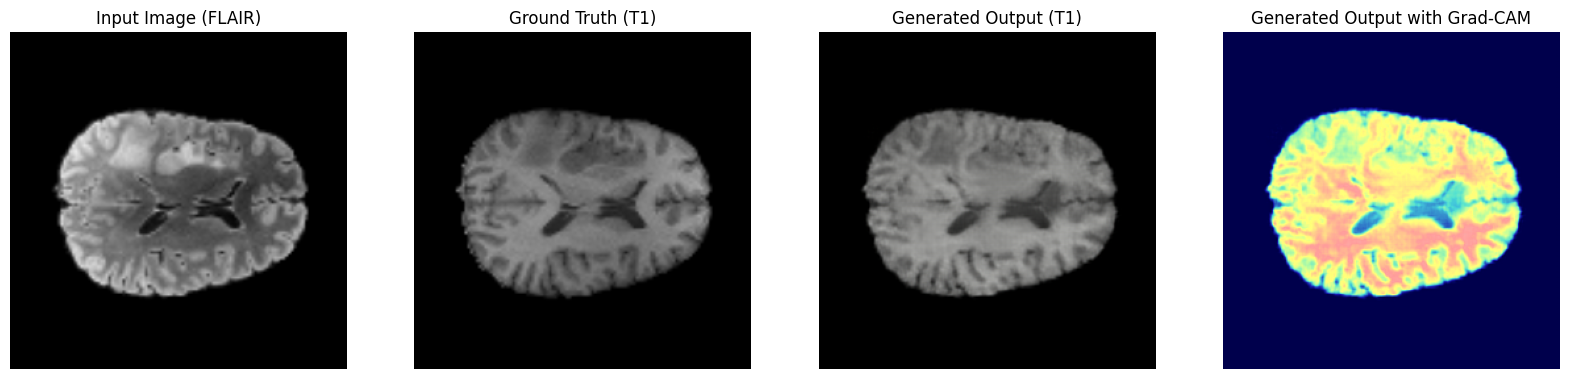

In [87]:
#displaying the final result- the input, generated output, and GradCam heatmap
device="cuda"

# Function to display images and GradCAM heatmap
def display_images(input_img, ground_truth_img, generated_img, heatmap, idx=0, alpha=0.6):
    """
    Displays the input image, ground truth, generated image, and Grad-CAM heatmap side by side.
    
    Parameters:
    - input_img: Tensor of input images (FLAIR)
    - ground_truth_img: Tensor of ground truth images (T1)
    - generated_img: Tensor of generated images (T1)
    - heatmap: The Grad-CAM heatmap to overlay
    - idx: Index of the image in the batch to display
    - alpha: Transparency of the heatmap overlay
    """
    # Detach tensors from the computation graph and convert them to numpy
    input_img = input_img[idx].cpu().detach().numpy().transpose((1, 2, 0))  # Detach and convert to numpy
    ground_truth_img = ground_truth_img[idx].cpu().detach().numpy().transpose((1, 2, 0))  # Detach and convert to numpy
    generated_img = generated_img[idx].cpu().detach().numpy().transpose((1, 2, 0))  # Detach and convert to numpy
    
    # Resize the heatmap to match the input image size
    heatmap_resized = np.resize(heatmap, (input_img.shape[0], input_img.shape[1]))
    
    # Create a heatmap in RGB 
    heatmap_rgb = plt.cm.jet(heatmap_resized)[:, :, :3]  # Discard the alpha channel
    
    # Apply the heatmap as an overlay on the generated image
    overlayed_img = np.clip(generated_img + alpha * heatmap_rgb, 0, 1)  # Ensure values are within [0, 1]
    
    # Plotting images with Grad-CAM overlay
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Display Input Image
    axes[0].imshow(input_img, cmap='gray')
    axes[0].set_title("Input Image (FLAIR)")
    axes[0].axis('off')

    # Display Ground Truth
    axes[1].imshow(ground_truth_img, cmap='gray')
    axes[1].set_title("Ground Truth (T1)")
    axes[1].axis('off')

    # Display Generated Image
    axes[2].imshow(generated_img, cmap='gray')
    axes[2].set_title("Generated Output (T1)")
    axes[2].axis('off')

    # Display Generated Image with Grad-CAM Overlay
    axes[3].imshow(overlayed_img)
    axes[3].set_title("Generated Output with Grad-CAM")
    axes[3].axis('off')

    plt.show()

# Get a batch of data
data_iter = iter(val_loader)
batch = next(data_iter)

# Move images to device
real_flair = batch['image'].to(device) 
real_t1 = batch['label'].to(device) 

# Select the target layer (last convolutional layer before Tanh)
target_layer = generator_flair_to_t1.model[24]

# Create GradCAM object
grad_cam = GradCAM(generator_flair_to_t1, target_layer)

# Ensure requires_grad is True for the input image (real_flair)
real_flair.requires_grad_()  # This enables gradient computation

# Generate output using the generator model (in evaluation mode)
generated_t1 = generator_flair_to_t1(real_flair)

# Generate GradCAM heatmap
heatmap = grad_cam.generate_heatmap(generated_t1)

# Convert heatmap to numpy for visualization
heatmap = heatmap.squeeze().cpu().detach().numpy()

# Display the images with Grad-CAM overlay
display_images(real_flair, real_t1, generated_t1, heatmap, idx=0)

# Clean up hooks
grad_cam.remove_hooks()
